In [1]:
# 钓鱼的过程可以看成一条马尔可夫链，每一秒像老虎机一样进行一次权重抽奖。权重池里有几种鱼的权重，还有空鱼权重。如果抽到空鱼权重，就再抽一次，直到抽到鱼权重。
# 但是我们可以用CDF的方法来模拟第几次抽到实鱼。
# 某种鱼的权重越高，抽到它的可能性就越大。权重的计算可以看成 基础权重 * 环境系数 * 适配系数，基础权重是配置在鱼场里的。
# 这个版本里，基础权重配置在probWeights表里，忽略环境系数，适配系数简化为鱼对手法的亲和度。
# 有两种算法，一种算法是每次抽奖都是独立的，不受上次抽奖的影响，重复抽。
# 另一种算法是，先算权重池抽到第一次鱼需要多少次的数学期望，再用ICDF转化，表示出次数的波动性，放在空鱼权重里。然后逐步扣减空鱼权重，知道扣减到0，表示抽到鱼。
# 
# 整体的时间逻辑为：
# 1. 初始化时，鱼权重为场次中配置的基础权重，空鱼权重为配置值，计算权重池，以及初始时间
# 2. 间歇性更新权重、更新时间。达到一定时间间隔，或穿越区域/跨越距离的条件下，统计玩家的操作技法，以及饵点的环境数据，更新权重池数据，并更新剩余时间。
# 3. 重复2，直到剩余时间为0/小于0（由于网络jitter、客户端卡顿等原因）则中鱼；
# 每一步中：
# 总权重 = sum（权重池中所有权重值）
# 实鱼权重 = 总权重 - 空鱼权重
# 
# 在路亚钓鱼玩法中，钓鱼的手法对鱼的抽奖权重有影响
# 简单的用手法和鱼对应的系数来计算，不引入状态、技法等概念
# 两条鱼,两种手法，足以展示波动性
# 使用一个xlsx来配置手法和鱼的系数

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

# 读取配置文件中所有worksheet的数据，返回多个dataframe
dfTrickAff = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='trickAff')
dfProbWeights = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='probWeights')
dfTrickSequence = pd.read_excel('exampleTables/trickFish.xlsx', sheet_name='playerTrickSequence')
print(dfTrickAff)
print(dfProbWeights) 
dfTrickSequence

  fishType  trick  aff
0      黄金鲈   抽搐手法  1.5
1     大口黑鲈   抽搐手法  1.0
2      黄金鲈  慢匀收手法  0.5
3     大口黑鲈  慢匀收手法  1.2
4       钓空   抽搐手法  1.0
5       钓空  慢匀收手法  1.0
  fishType  probWeight
0      黄金鲈         500
1     大口黑鲈         100
2       钓空       10000


,step,trick
0,0,慢匀收手法
1,1,慢匀收手法
2,2,慢匀收手法
3,3,慢匀收手法
4,4,慢匀收手法
...,...,...
251,251,慢匀收手法
252,252,抽搐手法
253,253,抽搐手法
254,254,抽搐手法


In [2]:
# 模拟一个玩家的手法变化的过程
trickSeq = dfTrickSequence['trick'].tolist()
print(trickSeq)

['慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '抽搐手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '慢匀收手法', '

In [3]:
dfTrickAff.set_index(['fishType', 'trick'], inplace=True)

# dfTrickAff用前两列作为组合键来查询亲和系数
def getAff(fishType, trick):
    return dfTrickAff.loc[(fishType, trick)]['aff']

# dfProbWeights用第一列作为键来查询权重
dfProbWeights.set_index(['fishType'], inplace=True)
def getProbWeights(fishType):
    return dfProbWeights.loc[fishType]['probWeight']

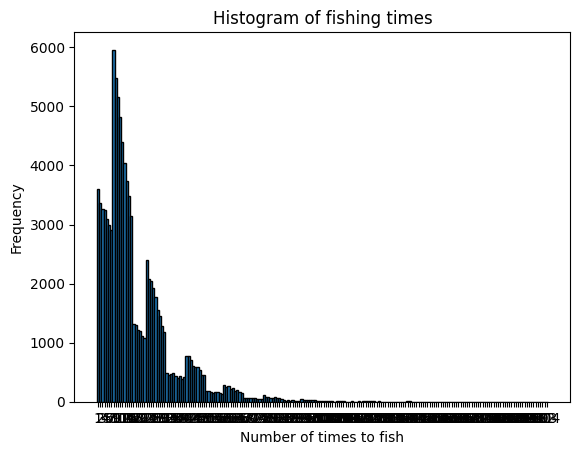

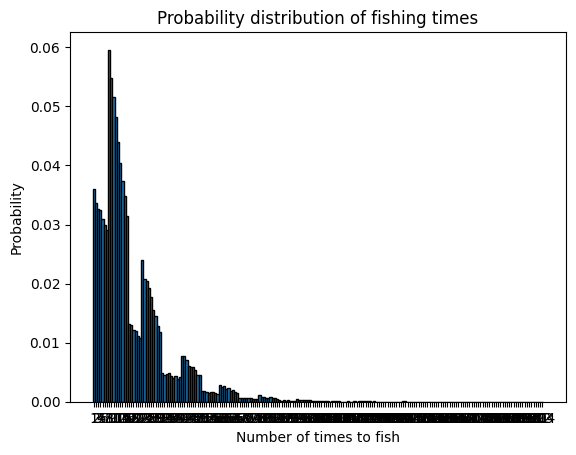

In [ ]:
import random
import matplotlib.pyplot as plt

# 预先计算所有鱼种的基准权重
probWeights = {fishType: getProbWeights(fishType) for fishType in dfProbWeights.index}

# 预先计算所有鱼种和手法的亲和度
aff = {fishType: {trick: getAff(fishType, trick) for trick in trickSeq} for fishType in dfProbWeights.index}

# 预先计算每次抽奖的权重列表
weights_per_trick = []
fishTypes = list(dfProbWeights.index)
for trick in trickSeq:
    weights = [probWeights[fishType] * aff[fishType][trick] for fishType in fishTypes]
    weights_per_trick.append(weights)

# 用方法一进行模拟一次
def fishSimulate1Time():
    for idx, weights in enumerate(weights_per_trick, start=1):
        selectedFish = random.choices(fishTypes, weights=weights, k=1)[0]
        if selectedFish != '钓空':
            return idx
    return len(trickSeq)

# 模拟很多次钓鱼，统计抽到鱼的次数，并画图
def fishSimulateNTimes(n):
    fishTimes = [fishSimulate1Time() for _ in range(n)]
    # 打印总次数、总时间、最大时间、最小时间、平均时间
    print('Total times:', n)
    print('Total fishing time:', sum(fishTimes))
    print('Max fishing time:', max(fishTimes))
    print('Min fishing time:', min(fishTimes))
    print('Average fishing time:', np.mean(fishTimes))

    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black')
    plt.xlabel('Number of times to fish')
    plt.ylabel('Frequency')
    plt.title('Histogram of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()
    # 再输出一个概率分布图
    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black', density=True)
    plt.xlabel('Number of times to fish')
    plt.ylabel('Probability')
    plt.title('Probability distribution of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()

fishSimulateNTimes(100000)

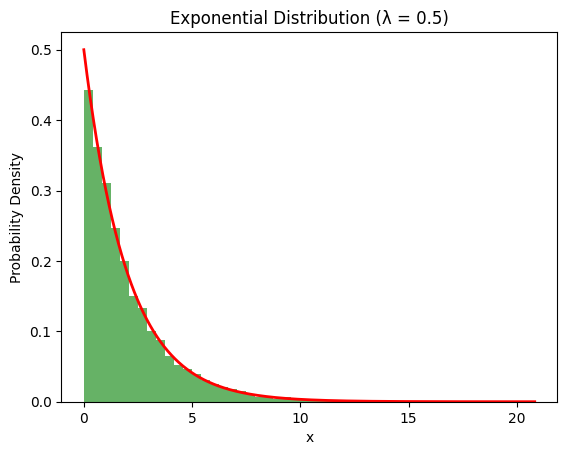

In [5]:
# 用第二种算法，先计算抽到鱼的期望次数，再用ICDF转化
# 期望次数 = 总权重/实鱼权重
# ICDF

import numpy as np
import matplotlib.pyplot as plt

def exponential_icdf(lambda_param, size=1):
    """
    使用逆累积分布函数法生成指数分布随机数

    参数:
    - lambda_param: 指数分布的 λ 参数（速率参数）
    - size: 生成随机数的数量

    返回:
    - samples: 服从指数分布的随机数数组
    """
    # 生成均匀分布的随机数 U
    U = np.random.uniform(0, 1, size)
    # 应用逆变换采样法，计算指数分布的随机变量
    samples = -np.log(U) / lambda_param
    return samples

# 设置 λ 参数，假设平均间隔时间 μ = 2，则 λ = 1 / μ = 0.5
lambda_param = 0.5

# 生成 10000 个随机样本
samples = exponential_icdf(lambda_param, size=10000)

# 绘制直方图
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# 绘制理论上的指数分布密度函数
x = np.linspace(0, samples.max(), 1000)
pdf = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, pdf, 'r', linewidth=2)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution (λ = {})'.format(lambda_param))
plt.show()

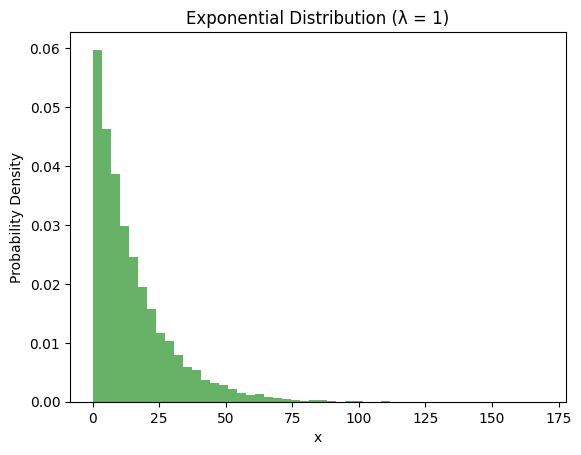

In [6]:
def simpleRandomICDF(lambda_param=0.5):
    return random.expovariate(lambda_param)

# 取1000次，查看分布
icdfs = [simpleRandomICDF(1/15) for _ in range(10000)]
plt.hist(icdfs, bins=50, density=True, alpha=0.6, color='g')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Exponential Distribution (λ = {})'.format(1))   
plt.show()

In [7]:
totalWeight = dfProbWeights['probWeight'].sum()
realFishWeight = totalWeight - dfProbWeights.loc['钓空']['probWeight']
expectedTimes = totalWeight / realFishWeight
lambda_param = 1 / expectedTimes
print(expectedTimes, lambda_param)

def getICDF(lambda_param):
    return random.expovariate(lambda_param)

# 用ICDF方法模拟一次
def getInitTimes(lambda_param):
    return int(np.ceil(getICDF(lambda_param)))

def initEmptyFishWeight():
    initTimes = getICDF(lambda_param)
    initEmptyFishWeight = realFishWeight * initTimes
    # print('initiating empty fish weight, initTimes:', initTimes)
    return initEmptyFishWeight

    

17.666666666666668 0.056603773584905655


In [8]:
weights_per_trick[0]

[250.0, 120.0, 10000.0]

总次数: 100000
总时间: 2090199
平均时间: 20.90199


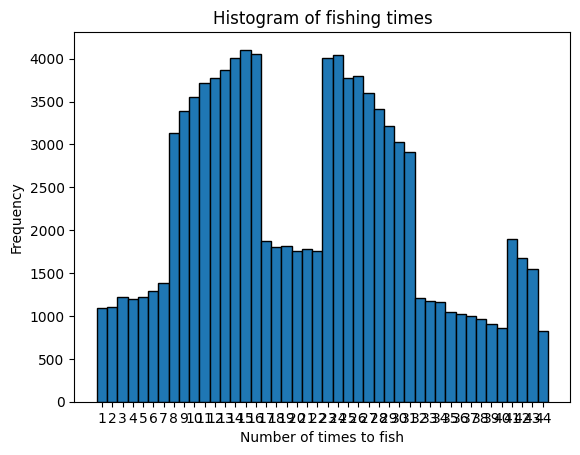

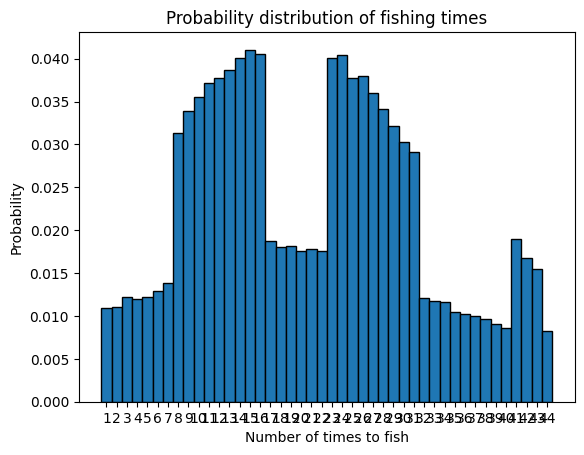

In [15]:
deltaTime = 1

# 用ICDF方法模拟一次
def fishSimulate1TimeICDF(log=False):
    # 初始化空鱼权重
    emptyFishWeight = initEmptyFishWeight()
    for idx, trick in enumerate(weights_per_trick, start=0):
        # 用手法带来的实鱼权重*deltaTime，扣减空鱼权重，直到小于等于0，则中鱼了
        fishWeights = weights_per_trick[idx]
        curRealFishWeight = sum(fishWeights[:2])
        emptyFishWeight -= curRealFishWeight * deltaTime
        if log:
            print('fishWeights:', fishWeights)
            print('curRealFishWeight:', curRealFishWeight)
            print('emptyFishWeight:', emptyFishWeight)
        if emptyFishWeight <= 0:
            if log:
                print(f'第{idx + 1}次抽中了鱼')
            return idx + 1
        
# 模拟很多次钓鱼，统计抽到鱼的次数，并画图
def fishSimulateNTimesICDF(n):
    fishTimes = [fishSimulate1TimeICDF() for _ in range(n)]
    # 打印总次数、总时间、平均时间
    print('总次数:', n)
    print('总时间:', sum(fishTimes))
    print('平均时间:', sum(fishTimes) / n)

    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black')
    plt.xlabel('Number of times to fish')
    plt.ylabel('Frequency')
    plt.title('Histogram of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()
    # 再输出一个概率分布图
    plt.hist(fishTimes, bins=range(1, max(fishTimes) + 2), align='left', edgecolor='black', density=True)
    plt.xlabel('Number of times to fish')
    plt.ylabel('Probability')
    plt.title('Probability distribution of fishing times')
    plt.xticks(range(1, max(fishTimes) + 1))
    plt.show()

fishSimulateNTimesICDF(100000)

总共模拟时间：1346049 秒
平均每次钓到鱼所用时间：11.19 秒
平均每次钓到鱼所用手法次数：11.19 次
平均两次钓到鱼之间的时间：19.16 秒
平均两次钓到鱼之间的手法次数：19.16 次


c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38035 (\N{CJK UNIFIED IDEOGRAPH-9493}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7

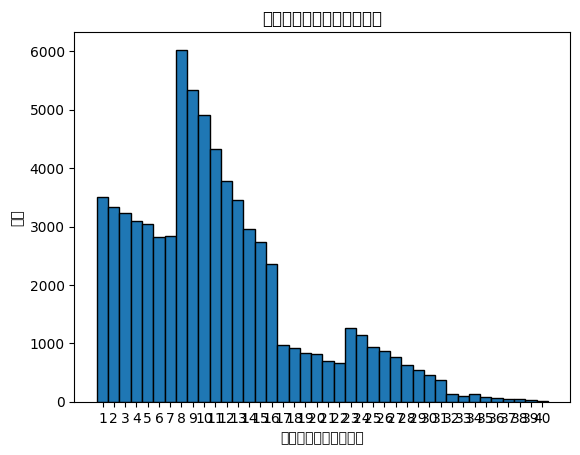

c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


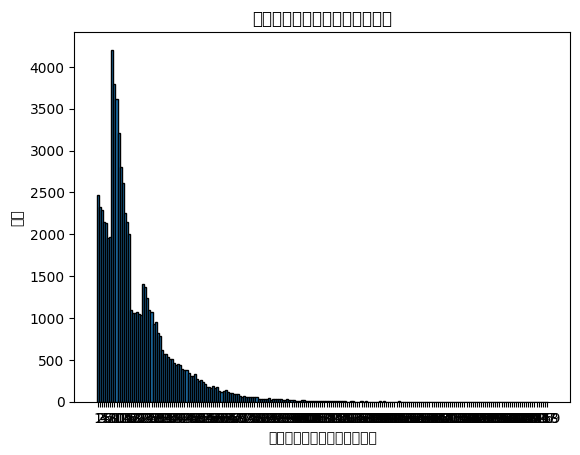

In [10]:
deltaTime = 1

# 用 ICDF 方法模拟一次钓鱼
def fishSimulate1TimeICDFWithLifts(maxTime):
    # 初始化空鱼权重
    emptyFishWeight = initEmptyFishWeight()
    # 累计经过的时间
    elapsedTime = 0
    trickCount = 0
    idx = 0
    while elapsedTime < maxTime:
        # 获取当前手法的权重，这里假设 weights_per_trick 已经预先计算好
        fishWeights = weights_per_trick[idx % len(weights_per_trick)]
        # 计算当前手法带来的实鱼权重
        curRealFishWeight = sum(fishWeights[:2])  # 假设前两个鱼种是目标鱼
        # 扣减空鱼权重
        emptyFishWeight -= curRealFishWeight * deltaTime
        # 增加经过的时间和手法计数
        elapsedTime += deltaTime
        trickCount += 1
        idx += 1
        # 判断是否钓到鱼
        if emptyFishWeight <= 0:
            # 返回钓到鱼的标志和所用时间
            return True, elapsedTime, trickCount
    # 如果在抬竿时间内未钓到鱼，返回未钓到鱼的标志和抬竿时间
    return False, maxTime, trickCount

# 模拟多次钓鱼，统计每次钓到鱼的时间，并绘制直方图
def fishSimulateNTimesICDFWithLifts(n):
    totalTime = 0
    timesBetweenCatches = []
    timesToCatch = []
    tricksBetweenCatches = []
    tricksToCatch = []
    timeSinceLastCatch = 0
    tricksSinceLastCatch = 0

    for _ in range(n):
        # 每次抛竿，让抬竿时间在 8 到 40 秒之间随机
        maxTime = random.randint(8, 40)
        # 模拟一次钓鱼
        caughtFish, timeUsed, tricksUsed = fishSimulate1TimeICDFWithLifts(maxTime)
        # 更新总时间和自上次钓到鱼的累计时间
        totalTime += timeUsed
        timeSinceLastCatch += timeUsed
        tricksSinceLastCatch += tricksUsed
        if caughtFish:
            # 记录钓到鱼所用的时间和手法次数
            timesToCatch.append(timeUsed)
            tricksToCatch.append(tricksUsed)
            # 记录两次钓到鱼之间的时间和手法次数
            timesBetweenCatches.append(timeSinceLastCatch)
            tricksBetweenCatches.append(tricksSinceLastCatch)
            # 重置自上次钓到鱼的累计时间和手法次数
            timeSinceLastCatch = 0
            tricksSinceLastCatch = 0

    # 输出统计信息
    print(f"总共模拟时间：{totalTime} 秒")
    print(f"平均每次钓到鱼所用时间：{sum(timesToCatch)/len(timesToCatch):.2f} 秒")
    print(f"平均每次钓到鱼所用手法次数：{sum(tricksToCatch)/len(tricksToCatch):.2f} 次")
    print(f"平均两次钓到鱼之间的时间：{sum(timesBetweenCatches)/len(timesBetweenCatches):.2f} 秒")
    print(f"平均两次钓到鱼之间的手法次数：{sum(tricksBetweenCatches)/len(tricksBetweenCatches):.2f} 次")

    # 绘制钓到鱼所用时间的分布直方图
    plt.hist(timesToCatch, bins=range(int(min(timesToCatch)), int(max(timesToCatch)) + 2), align='left', edgecolor='black')
    plt.xlabel('钓到鱼所用时间（秒）')
    plt.ylabel('频率')
    plt.title('钓到鱼所用时间分布直方图')
    plt.xticks(range(int(min(timesToCatch)), int(max(timesToCatch)) + 1))
    plt.show()

    # 绘制两次钓到鱼之间时间的分布直方图
    plt.hist(timesBetweenCatches, bins=range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 2), align='left', edgecolor='black')
    plt.xlabel('两次钓到鱼之间的时间（秒）')
    plt.ylabel('频率')
    plt.title('两次钓到鱼之间时间分布直方图')
    plt.xticks(range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 1))
    plt.show()

# 运行模拟
fishSimulateNTimesICDFWithLifts(100000)

In [11]:
from scipy.special import erfinv
from scipy.stats import truncnorm

# 现在将ICDF修改为截断的正态分布ICDF，重新进行模拟
def truncated_normal_icdf(mu, sigma, a, b, size=1):
    """
    使用逆累积分布函数法生成截断正态分布随机数

    参数:
    - mu: 正态分布的均值
    - sigma: 正态分布的标准差
    - a: 截断区间的下界
    - b: 截断区间的上界
    - size: 生成随机数的数量

    返回:
    - samples: 服从截断正态分布的随机数数组
    """
    # 计算截断正态分布的标准化上下界
    a, b = (a - mu) / sigma, (b - mu) / sigma
    # 生成截断正态分布的随机数
    samples = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=size)
    return samples

def getICDF(lambda_param=1/15)->float:
    timeExpect = 1/lambda_param
    return truncated_normal_icdf(timeExpect, timeExpect,0, 2.5 * timeExpect, 1).item()


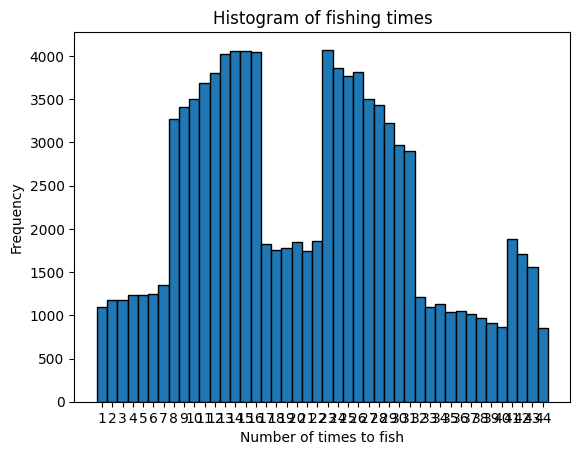

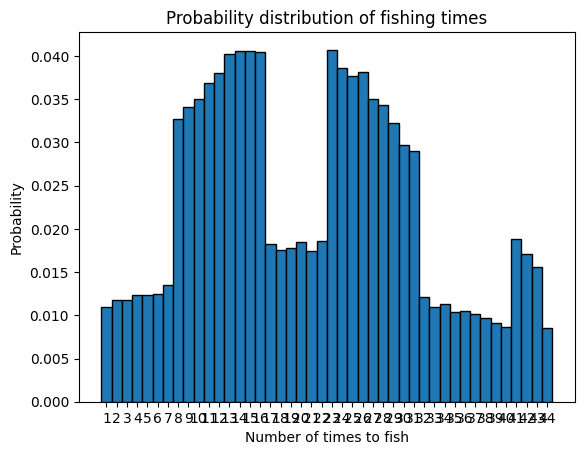

In [ ]:
# 不收竿再抛，每次钓到中鱼为止，统计中鱼时间的分布
fishSimulateNTimesICDF(100000)

# 每次都等到中鱼的情况下，统计平均中鱼时间


总共模拟时间：1468865 秒
平均每次钓到鱼所用时间：13.47 秒
平均每次钓到鱼所用手法次数：13.47 次
平均两次钓到鱼之间的时间：21.58 秒
平均两次钓到鱼之间的手法次数：21.58 次


c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38035 (\N{CJK UNIFIED IDEOGRAPH-9493}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7

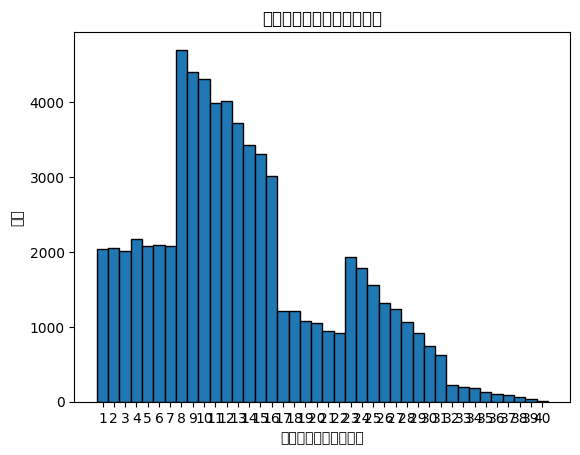

c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


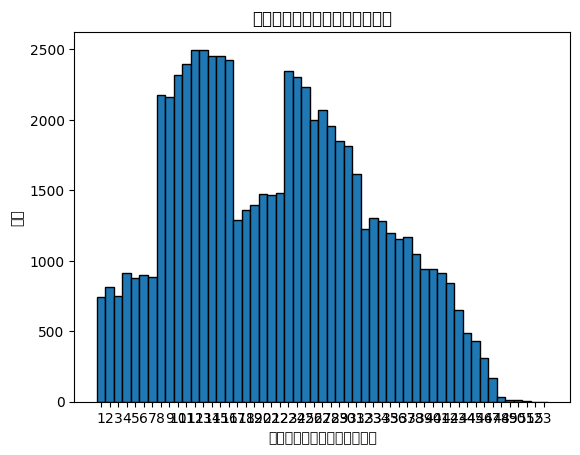

In [14]:
# 如果抬放竿，但是不延续上一次的空鱼权重，重新开始计时，会使得中鱼时间比期望时间变长
fishSimulateNTimesICDFWithLifts(100000)

总共模拟时间：1472592 秒
平均每次钓到鱼所用时间：13.53 秒
平均每次钓到鱼所用手法次数：13.53 次
平均两次钓到鱼之间的时间：21.61 秒
平均两次钓到鱼之间的手法次数：21.61 次


c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38035 (\N{CJK UNIFIED IDEOGRAPH-9493}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40060 (\N{CJK UNIFIED IDEOGRAPH-9C7

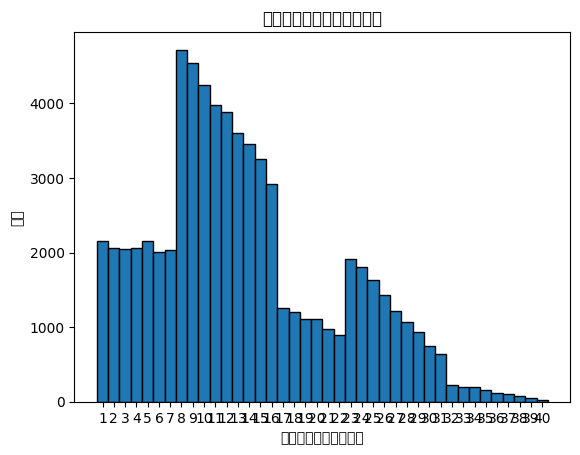

c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\futou\.conda\envs\fish\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


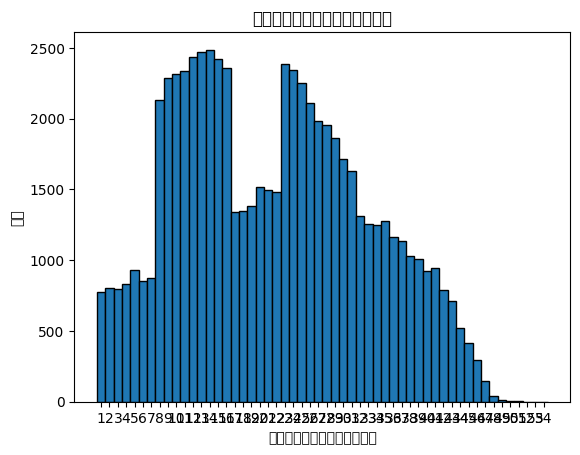

In [13]:
deltaTime = 1

# 用 ICDF 方法模拟一次钓鱼（带连续空鱼权重）
def fishSimulate1TimeICDFWithLifts_Continuous(maxTime, emptyFishWeight):
    # 累计经过的时间
    elapsedTime = 0
    trickCount = 0
    idx = 0
    while elapsedTime < maxTime:
        # 获取当前手法的权重，这里假设 weights_per_trick 已经预先计算好
        fishWeights = weights_per_trick[idx % len(weights_per_trick)]
        # 计算当前手法带来的实鱼权重
        curRealFishWeight = sum(fishWeights[:2])  # 假设前两个鱼种是目标鱼
        # 扣减空鱼权重
        emptyFishWeight -= curRealFishWeight * deltaTime
        # 增加经过的时间和手法计数
        elapsedTime += deltaTime
        trickCount += 1
        idx += 1
        # 判断是否钓到鱼
        if emptyFishWeight <= 0:
            # 钓到鱼，返回结果并重置空鱼权重
            return True, elapsedTime, trickCount, initEmptyFishWeight()
    # 未钓到鱼，返回结果和当前空鱼权重
    return False, elapsedTime, trickCount, emptyFishWeight

# 模拟多次钓鱼，统计每次钓到鱼的时间，并绘制直方图
def fishSimulateNTimesICDFWithLifts(n):
    totalTime = 0
    timesBetweenCatches = []
    timesToCatch = []
    tricksBetweenCatches = []
    tricksToCatch = []
    timeSinceLastCatch = 0
    tricksSinceLastCatch = 0
    emptyFishWeight = initEmptyFishWeight()  # 初始化空鱼权重

    for _ in range(n):
        # 每次抛竿，让抬竿时间在 8 到 40 秒之间随机
        maxTime = random.randint(8, 40)
        # 模拟一次钓鱼
        caughtFish, timeUsed, tricksUsed, emptyFishWeight = fishSimulate1TimeICDFWithLifts_Continuous(maxTime, emptyFishWeight)
        # 更新总时间和自上次钓到鱼的累计时间
        totalTime += timeUsed
        timeSinceLastCatch += timeUsed
        tricksSinceLastCatch += tricksUsed
        if caughtFish:
            # 记录钓到鱼所用的时间和手法次数
            timesToCatch.append(timeUsed)
            tricksToCatch.append(tricksUsed)
            # 记录两次钓到鱼之间的时间和手法次数
            timesBetweenCatches.append(timeSinceLastCatch)
            tricksBetweenCatches.append(tricksSinceLastCatch)
            # 重置自上次钓到鱼的累计时间和手法次数
            timeSinceLastCatch = 0
            tricksSinceLastCatch = 0
            emptyFishWeight = initEmptyFishWeight()  # 重置空鱼权重

    # 输出统计信息
    print(f"总共模拟时间：{totalTime} 秒")
    print(f"平均每次钓到鱼所用时间：{sum(timesToCatch)/len(timesToCatch):.2f} 秒")
    print(f"平均每次钓到鱼所用手法次数：{sum(tricksToCatch)/len(tricksToCatch):.2f} 次")
    print(f"平均两次钓到鱼之间的时间：{sum(timesBetweenCatches)/len(timesBetweenCatches):.2f} 秒")
    print(f"平均两次钓到鱼之间的手法次数：{sum(tricksBetweenCatches)/len(tricksBetweenCatches):.2f} 次")

    # 绘制钓到鱼所用时间的分布直方图
    plt.hist(timesToCatch, bins=range(int(min(timesToCatch)), int(max(timesToCatch)) + 2), align='left', edgecolor='black')
    plt.xlabel('钓到鱼所用时间（秒）')
    plt.ylabel('频率')
    plt.title('钓到鱼所用时间分布直方图')
    plt.xticks(range(int(min(timesToCatch)), int(max(timesToCatch)) + 1))
    plt.show()

    # 绘制两次钓到鱼之间时间的分布直方图
    plt.hist(timesBetweenCatches, bins=range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 2), align='left', edgecolor='black')
    plt.xlabel('两次钓到鱼之间的时间（秒）')
    plt.ylabel('频率')
    plt.title('两次钓到鱼之间时间分布直方图')
    plt.xticks(range(int(min(timesBetweenCatches)), int(max(timesBetweenCatches)) + 1))
    plt.show()

# 运行模拟
fishSimulateNTimesICDFWithLifts(100000)